In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import datetime as dt
import yfinance as yf
import copy

In [66]:
def CAGR(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["mon_ret"]).cumprod()
    n=len(df)/12 #252 trading days #252*8 trading hours
    CAGR=(df["cum_return"].tolist()[-1])**(1/n) -1
    return CAGR

In [72]:
def volatility(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    vol=df["mon_ret"].std()*np.sqrt(12)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [21]:
def sharpe(DF,rf):
    df=DF.copy()
    return ((CAGR(df)-rf)/volatility(df))

In [75]:
def max_dd(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["mon_ret"]).cumprod()
    df["cum_roll_max"]=df["cum_return"].cummax()
    df["drawdown"]=df["cum_roll_max"]-df["cum_return"]
    df["drawdown_pct"]=df["drawdown"]/df["cum_roll_max"]
    return df["drawdown_pct"].max()

In [23]:
def calmar(DF):
    df=DF.copy()
    return CAGR(df)/max_dd(DF)

In [83]:
tickers=["AAPL","TSLA","AMD","NVDA","TWTR","HP","AMZN","XOM"]

In [84]:
ohlc_mon={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(3650)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_mon[ticker]=yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")

tickers=ohlc_mon.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [85]:
tickers

dict_keys(['AAPL', 'TSLA', 'AMD', 'NVDA', 'TWTR', 'HP', 'AMZN', 'XOM'])

In [86]:
#calculating monthly return for each stock and consolidating return info by stock in a seperate dataframe
ohlc_dict=copy.deepcopy(ohlc_mon)
return_df=pd.DataFrame()

for ticker in tickers:
    print("Calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"]=ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker]=ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

Calculating monthly return for  AAPL
Calculating monthly return for  TSLA
Calculating monthly return for  AMD
Calculating monthly return for  NVDA
Calculating monthly return for  TWTR
Calculating monthly return for  HP
Calculating monthly return for  AMZN
Calculating monthly return for  XOM


In [87]:
return_df

,AAPL,TSLA,AMD,NVDA,TWTR,HP,AMZN,XOM
Date,,,,,,,,
2014-01-01,-0.107697,0.205943,-0.113695,-0.019975,0.013354,0.047098,-0.100554,-0.089328
2014-02-01,0.051218,0.349485,0.081633,0.170700,-0.148682,0.121650,0.009507,0.044596
2014-03-01,0.026058,-0.148523,0.080863,-0.021171,-0.150064,0.096998,-0.071058,0.021833
2014-04-01,0.099397,-0.002686,0.019950,0.031267,-0.164988,0.010134,-0.095847,0.048424
2014-05-01,0.072717,-0.000577,-0.022005,0.028695,-0.167565,0.011965,0.027685,-0.018358
...,...,...,...,...,...,...,...,...
2022-05-01,-0.055883,-0.129197,0.191066,0.006740,-0.192167,0.093852,-0.032764,0.126100
2022-06-01,-0.080080,-0.111888,-0.249264,-0.188143,-0.055808,-0.139970,-0.116459,-0.098779
2022-07-01,0.188634,0.323765,0.235386,0.198419,0.112864,0.075244,0.270596,0.131831


In [88]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """
    Returns cumulative portfolio return
    DF=dataframe with monthly return info for all stocks
    m=number of stock in the portfolio
    x=number of underperforming stocks to be removed from portfolio monthly
    """
    df=DF.copy()
    portfolio=[]
    monthly_ret=[0]
    
    for i in range(len(df)):
        if len(portfolio)>0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks=df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio=[t for t in portfolio if t not in bad_stocks]
        fill=m-len(portfolio)
        #new_picks=df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        new_picks=df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist() #with replacement
        portfolio=portfolio+new_picks
        print(portfolio)
    monthly_ret_df=pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    
    return monthly_ret_df

In [89]:
pflio(return_df,6,3)

['TSLA', 'HP', 'TWTR', 'NVDA', 'XOM', 'AMZN']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'XOM', 'NVDA', 'AMZN']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'TSLA', 'XOM']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'XOM', 'NVDA', 'AMD']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'XOM', 'AMZN', 'HP']
['NVDA', 'AAPL', 'XOM', 'TSLA', 'AMZN', 'HP']
['NVDA', 'AAPL', 'AMZN', 'TSLA', 'TWTR', 'AMD']
['NVDA', 'AAPL', 'AMD', 'XOM', 'HP', 'AMZN']
['AAPL', 'AMD', 'AMZN', 'TWTR', 'NVDA', 'XOM']
['AMD', 'TWTR', 'NVDA', 'HP', 'AAPL', 'AMZN']
['TWTR', 'HP', 'AMZN', 'AAPL', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'XOM', 'AAPL']
['AMZN', 'TSLA', 'AAPL', 'AMD', 'NVDA', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'NVDA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'TSLA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'AMD'

,mon_ret
0,0.000000
1,0.091209
2,0.009343
3,0.018887
4,0.012073
...,...
100,0.005628
101,-0.145449
102,0.183822
103,0.011931


# calculating overall strategy's KPIs

In [90]:
CAGR(pflio(return_df,6,3))

['TSLA', 'HP', 'TWTR', 'NVDA', 'XOM', 'AMZN']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'XOM', 'NVDA', 'AMZN']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'TSLA', 'XOM']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'XOM', 'NVDA', 'AMD']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'XOM', 'AMZN', 'HP']
['NVDA', 'AAPL', 'XOM', 'TSLA', 'AMZN', 'HP']
['NVDA', 'AAPL', 'AMZN', 'TSLA', 'TWTR', 'AMD']
['NVDA', 'AAPL', 'AMD', 'XOM', 'HP', 'AMZN']
['AAPL', 'AMD', 'AMZN', 'TWTR', 'NVDA', 'XOM']
['AMD', 'TWTR', 'NVDA', 'HP', 'AAPL', 'AMZN']
['TWTR', 'HP', 'AMZN', 'AAPL', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'XOM', 'AAPL']
['AMZN', 'TSLA', 'AAPL', 'AMD', 'NVDA', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'NVDA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'TSLA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'AMD'

0.31145247681895394

In [91]:
sharpe(pflio(return_df,6,3),0.025)

['TSLA', 'HP', 'TWTR', 'NVDA', 'XOM', 'AMZN']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'XOM', 'NVDA', 'AMZN']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'TSLA', 'XOM']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'XOM', 'NVDA', 'AMD']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'XOM', 'AMZN', 'HP']
['NVDA', 'AAPL', 'XOM', 'TSLA', 'AMZN', 'HP']
['NVDA', 'AAPL', 'AMZN', 'TSLA', 'TWTR', 'AMD']
['NVDA', 'AAPL', 'AMD', 'XOM', 'HP', 'AMZN']
['AAPL', 'AMD', 'AMZN', 'TWTR', 'NVDA', 'XOM']
['AMD', 'TWTR', 'NVDA', 'HP', 'AAPL', 'AMZN']
['TWTR', 'HP', 'AMZN', 'AAPL', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'XOM', 'AAPL']
['AMZN', 'TSLA', 'AAPL', 'AMD', 'NVDA', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'NVDA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'TSLA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'AMD'

1.0958940927130967

In [92]:
max_dd(pflio(return_df,6,3))

['TSLA', 'HP', 'TWTR', 'NVDA', 'XOM', 'AMZN']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'XOM', 'NVDA', 'AMZN']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'TSLA', 'XOM']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'XOM', 'NVDA', 'AMD']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'XOM', 'AMZN', 'HP']
['NVDA', 'AAPL', 'XOM', 'TSLA', 'AMZN', 'HP']
['NVDA', 'AAPL', 'AMZN', 'TSLA', 'TWTR', 'AMD']
['NVDA', 'AAPL', 'AMD', 'XOM', 'HP', 'AMZN']
['AAPL', 'AMD', 'AMZN', 'TWTR', 'NVDA', 'XOM']
['AMD', 'TWTR', 'NVDA', 'HP', 'AAPL', 'AMZN']
['TWTR', 'HP', 'AMZN', 'AAPL', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'XOM', 'AAPL']
['AMZN', 'TSLA', 'AAPL', 'AMD', 'NVDA', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'NVDA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'TSLA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'AMD'

0.29896680228905176

# calculating KPIs for Index buy and hold strategy over the same period

In [93]:
DJI=yf.download("^DJI",start=dt.date.today()-dt.timedelta(3650),end=dt.date.today(),interval='1mo')
DJI["mon_ret"]=DJI["Adj Close"].pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [94]:
DJI

,Open,High,Low,Close,Adj Close,Volume,mon_ret
Date,,,,,,,
2012-09-01,13092.150391,13653.240234,12977.089844,13437.129883,13437.129883,2701270000,0.000000
2012-10-01,13437.660156,13661.870117,13017.370117,13096.459961,13096.459961,2472600000,-0.025353
2012-11-01,13099.190430,13290.750000,12471.490234,13025.580078,13025.580078,2683930000,-0.005412
2012-12-01,13027.730469,13365.860352,12883.889648,13104.139648,13104.139648,2666750000,0.006031
2013-01-01,13104.299805,13969.990234,13104.299805,13860.580078,13860.580078,2786680000,0.057725
...,...,...,...,...,...,...,...
2022-04-01,34740.890625,35492.218750,32913.148438,32977.210938,32977.210938,7146800000,-0.049055
2022-05-01,32978.488281,34117.738281,30635.759766,32990.121094,32990.121094,8934160000,0.000391
2022-06-01,33156.308594,33272.339844,29653.289062,30775.429688,30775.429688,7655170000,-0.067132


In [95]:
CAGR(DJI)

0.09335532761514687

In [96]:
sharpe(DJI,0.025)

0.4960460445300409

In [97]:
max_dd(DJI)

0.2320126616506342

# Visualization

['TSLA', 'HP', 'TWTR', 'NVDA', 'XOM', 'AMZN']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'XOM', 'NVDA', 'AMZN']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'TSLA', 'XOM']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'XOM', 'NVDA', 'AMD']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'XOM', 'AMZN', 'HP']
['NVDA', 'AAPL', 'XOM', 'TSLA', 'AMZN', 'HP']
['NVDA', 'AAPL', 'AMZN', 'TSLA', 'TWTR', 'AMD']
['NVDA', 'AAPL', 'AMD', 'XOM', 'HP', 'AMZN']
['AAPL', 'AMD', 'AMZN', 'TWTR', 'NVDA', 'XOM']
['AMD', 'TWTR', 'NVDA', 'HP', 'AAPL', 'AMZN']
['TWTR', 'HP', 'AMZN', 'AAPL', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'XOM', 'AAPL']
['AMZN', 'TSLA', 'AAPL', 'AMD', 'NVDA', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'NVDA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'TSLA', 'AAPL', 'TWTR']
['AMZN', 'XOM', 'NVDA', 'AMD'

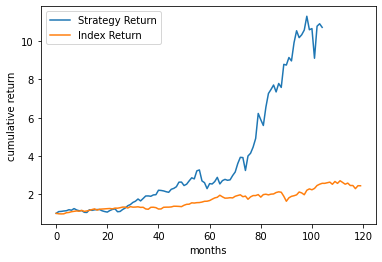

In [98]:
fig,ax=plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])

# Implement this technique for shorting